## Computational Perception Assignment 2
Brennan McFarland

### Imports

In [190]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

### Q1. Entropy (30 points)

1.1 (5 points) Write code to generate $N$ random samples from a 1) a uniform distribution, 2) a normal distribution, and 3) a sparse (leptokurtic) distribution of your choosing (or whatever is available in your the statistics library).  Plot histograms for your samples.

In [191]:
def my_uniform(n, low=0.0, high=1.0):
    return np.array([np.random.uniform(low, high) for _ in range(n)])

def my_normal(n, mu=0.0, sigma=1.0):
    return np.array([np.random.normal(mu, sigma) for _ in range(n)])

def my_sparse(n, loc=0.0, scale=1.0):
    return np.array([np.random.laplace(loc, scale) for _ in range(n)])

In [192]:
# test the distributions by matching against numpy functions with the same random seed
random.seed(24601) # who am I?
np.random.seed(24601)

my_funcs = (my_uniform, my_normal, my_sparse)
func_names = ('uniform', 'normal', 'laplace')
np_funcs = (np.random.uniform, np.random.normal, np.random.laplace)

n = 5
for func_name, my_func, np_func in zip(func_names, my_funcs, np_funcs):
    random.seed(24601) # who am I?
    np.random.seed(24601)
    my_output = my_func(n)
    random.seed(24601) # who am I?
    np.random.seed(24601)
    
    np_output = np_func(size=n)
    difference = my_output - np_output
    print(func_name, " My output: ",my_output, " Numpy output: ", np_output, " Difference: ", difference)
    assert np.array_equal(my_output, np_output)
print("No assertion failures, all functions equivalent")

uniform  My output:  [0.79575799 0.58931258 0.25328092 0.74791299 0.8642763 ]  Numpy output:  [0.79575799 0.58931258 0.25328092 0.74791299 0.8642763 ]  Difference:  [0. 0. 0. 0. 0.]
normal  My output:  [ 0.40116503  1.32845523  0.84745472 -0.8433735   1.19246689]  Numpy output:  [ 0.40116503  1.32845523  0.84745472 -0.8433735   1.19246689]  Difference:  [0. 0. 0. 0. 0.]
laplace  My output:  [ 0.89530249  0.19677571 -0.68010886  0.68483379  1.30398689]  Numpy output:  [ 0.89530249  0.19677571 -0.68010886  0.68483379  1.30398689]  Difference:  [0. 0. 0. 0. 0.]
No assertion failures, all functions equivalent


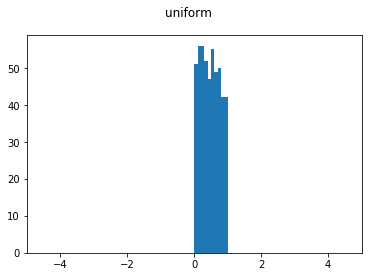

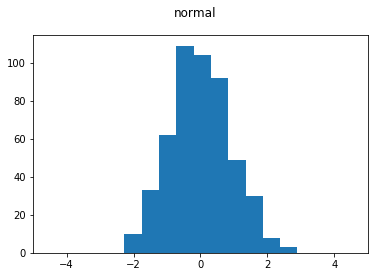

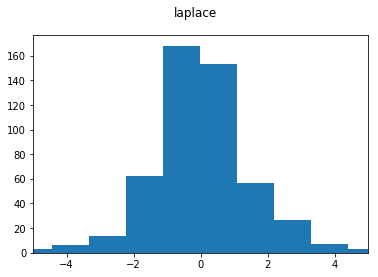

In [193]:
# plot histograms
n=500
for func_name, my_func in zip(func_names, my_funcs):
    histogram = np.histogram(my_func(n))  
    plt.hist(my_func(n))
    plt.xlim((-5, 5))
    plt.gcf().suptitle(func_name)
    plt.show()

1.2 (5 points) Write a function that *computes* a histogram (e.g. computes the counts for a set of bins).  You can use library functions (e.g. in [fit(Histogram, ...)](http://juliastats.github.io/StatsBase.jl/latest/empirical.html#Histograms) in julia or [numpy.histogram](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.histogram.html) in python)).  Your bins should be evenly spaced within a range.

In [194]:
def compute_histogram(arr, hist_bins=10, hist_range=(-1, 1)):
    histogram = np.histogram(arr, bins=hist_bins, range=hist_range)
    return histogram

In [195]:
# for good measure, here's a function to plot it
def plot_histogram(histogram):
    plt.bar(histogram[1][:-1], histogram[0]) # we get rid of the last element because we don't need the upper bound of the max
    plt.show()

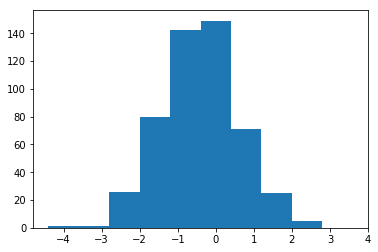

In [196]:
# test the function on a normal distribution
histogram = compute_histogram(np.random.normal(size=500), hist_range=(-4, 4))
plot_histogram(histogram)

1.3 (5 points) Write a function to calculate the entropy

$$
-\sum_x p(x) \log_2 p(x)
$$
given a vector of counts.  It should properly handle bins with zero count. 

In [197]:
# the entropy can of course be >1 because it's not binary
def entropy(counts):
    probs = counts / np.sum(counts)
    log_probs = np.log2(probs)
    entropy = -np.nansum(probs*log_probs) # nansum makes it treat log(0) as 0 (since it returns nan), so 0 counts work
    return entropy

In [198]:
# test on normal distribution
counts = compute_histogram(np.random.normal(size=500), hist_range=(-4, 4))[0]
ent = entropy(counts)
print(ent)

2.451535584349514


/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


1.4 (5 points) Estimate the entropy using the distributions above, using $2^k$ bins and the same bin boundaries for each.  Explain the differences in the entropy estimates and how they compare to the capacity of a $k$-bit binary code.

In [199]:
# TODO: the entropy changes for different values of k, but this is ok since higher k means more buckets means
# lower probability of being in any given bucket, which affects entropy
k = 5
bins = 2 ** k
n = 1000

for func_name, my_func in zip(func_names, my_funcs):
    counts = compute_histogram(my_func(n), hist_bins=bins, hist_range=(-5, 5))[0]
    ent = entropy(counts)
    print(func_name, ent)
print('capacity ', np.log2(n))

uniform 1.8115382593323812
normal 3.6671997309535023
laplace 4.005958614656732
capacity  9.965784284662087


/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


1.5 (5 points) Use your function to estimate the entropy of an image (or sound) from the pixels (or samples).

In [207]:
# the range of possible values is 0-1, so we'll calculate entropy over that
def entropy_of_image_file(filename, k=5):
    path = 'data/' + filename
    img = imread(path).flatten()
    counts = compute_histogram(img, hist_range=(0, 1), hist_bins=2**k)[0]
    ent = entropy(counts)
    return ent

In [208]:
ent = entropy_of_image_file('flam3.png')
print(ent)

3.7048515199192886


1.6 (5 points) Find and plot low- and high-entropy examples of images (or sounds).  What type would have the highest entropy?  The lowest?

In [212]:
print('low entropy:')
print(entropy_of_image_file('IMG_0697.JPG'))
print('high entropy:')
print(entropy_of_image_file('intro_img.png'))

low entropy:
0.9916869786766787
high entropy:
1.8982165641679714


/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


highest entropy: all same shade of grey/black/white?
lowest entropy: pure noise?

### Q2. 1D Channel Coding (30 points)

2.1 (5 pts) Write a function that takes a vector of real-valued numbers and quantizes them into $n$ evenly-spaced bins, replacing each with either the bin center value or randomizing the values within the bin.

2.2 (5 pts) Write another function that takes the quantized values and computes the "reconstruction" error compared to the original signal.

2.3 (10 points) Write a function that computes a non-linear transform of the data above to minimize the reconstruction error of the quantized, transformed values.  Explain and illustrate your approach.

2.4 (5 points) Explain how the transform is making optimal use of the capacity of this channel.

2.5 (5 points) Use this function to illustrate coding of the low- and high-entropy signals you used in the previous question.

### Q3. Coding with Basis Functions (25 points)

3.1 (5 points) Find a toolbox / package for computing 2D wavelet transforms.  Plot the wavelet transform for your images above (or 1D wavelet if you used sounds).  You can either Haar or Daubechies wavelets, but feel free to explore others.

3.2 (10 points) Write a function to plot the wavelet basis functions by apply the inverse transform to delta function in the coeficients.  Use a small (e.g. 8x8 or 16x16) image to limit the number of basis functions you have to plot.

3.3 (10 points) Apply your quantization coding functions above to the wavelet coefficients and illustrate how this code compares to coding the quantized pixels.

### Q4. Exploration (15 points)

In this section, you are meant to do creative exploration.  Select a concept or topic you want to understand better that is related to the problems in this assignment or is in the readings.  Explore it, and write up and illustrate what you tried and learned.  The general idea is for you to teaching yourself, and it should read like a (relatively brief) tutorial.

Here is the grading rubric:

- Was the topic clearly described and concise? (5 pts)

- Were the relevant concepts clearly explained? (5 pts)

- Did the problem go beyond or is distinct from what was already convered in the questions above? (5 pts)